In [1]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt 
import pickle 
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import ttest_ind,  shapiro, mannwhitneyu, pearsonr
import seaborn as sb

plt.rcParams.update({'font.size': 16})
N_episode = 300
FIGSIZE = (16,9)
colors = ['crimson', 'royalblue', 'darkgreen', 'orange', 'blueviolet', 'cyan']
LW = 5

In [2]:
def plot_performance(data, X=None, names=None, title="", ylabel="performance", 
                     minimum = -np.inf, maximum=np.inf, log=False, double=False, xlabel="learning episodes"):
    """
    data = [n_param, n_run, episode_length]
    """
    
    if names is None:
        names = [str(j) for j in range(len(data))]
    compute_X = (X is None)
    if len(data)<6:
        ncol = [1,1,2,2,3][len(data)-1] 
    else:
        ncol = len(data)//2
    fig, ax = plt.subplots(figsize=FIGSIZE)
    handles = []
    for i in range(len(data)):
        if (double and i>=len(data)/2):
            linestyle = ":"
            color = colors[i%(len(data)//2)]
        else:
            linestyle = "-"
            color = colors[i%len(colors)]
        
        mean, std = np.mean(data[i], axis=0), np.std(data[i], axis=0)
        mean_p_std = np.minimum(mean+std, maximum)
        mean_m_std = np.maximum(mean-std, minimum)
        
        if compute_X:
            X = [x for x in range(len(mean))]

        for run in range(len(data[i])):
            plt.plot(X, data[i][run], color=color, lw=2, alpha=0.3, linestyle=linestyle)
        plt.plot(X,mean, color = color,lw=LW, linestyle=linestyle)
       # ax.fill_between(X,mean_p_std , mean_m_std, color= color, alpha=0.15)
       # plt.plot(X, mean_p_std, color=color, alpha=0.2)
        #plt.plot(X, mean_m_std, color=color, alpha=0.2)
        handles.append( mlines.Line2D([], [], color = color, linestyle=linestyle, label= names[i]))
    if log:
        plt.yscale("log")
        #if (X[1]-X[0])!=(X[-1]-X[-2]):
        #    plt.xscale("log")
    else:
        if minimum != -np.inf and maximum!=np.inf:
            plt.ylim(minimum,maximum)
        elif minimum != -np.inf:
            plt.ylim(minimum)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(handles=handles, numpoints = 2,ncol=1,bbox_to_anchor=(1.01, 1.))
    plt.show()

In [3]:
def truncate(f, n):
    '''Truncates/pads a float f to n decimal places without rounding'''
    s = '{}'.format(f)
    if 'e' in s or 'E' in s:
        return '{0:.{1}f}'.format(f, n)
    i, p, d = s.partition('.')
    return '.'.join([i, (d+'0'*n)[:n]])

def compute_test(data, coef=1, N=5):
    pairs = []
    for i in range(N-1):
        for j in range(i+1,N):
            pairs.append((i,j))
    res = [[] for _ in range(N)]
    cells = [[ '' for _ in range(N-1)] for _ in range(N-1)]
    for (param1,param2) in pairs:
        data1 = np.array(data[param1])
        data2 = np.array(data[param2])
        stat, p_t = ttest_ind(data1,data2)
        p_t = p_t*coef
        d = truncate( np.mean(data1)-np.mean(data2), 2)
        if d=='0.00' or d=='-0.00':
            d = truncate( np.mean(data1)-np.mean(data2), 3)
            if d=='0.000' or d=='-0.000':
                d = truncate( np.mean(data1)-np.mean(data2), 4)
        if p_t < 0.001:
            res.append((param1, param2, '***'))
            cells[param1][N-1-param2] = d+'\n***'
        elif p_t < 0.01:
            res.append((param1, param2, '**'))
            cells[param1][N-1-param2] = d+'\n**'
        elif p_t < 0.05:
            res.append((param1, param2, '*'))
            cells[param1][N-1-param2] = d+'\n*'
        else:
            cells[param1][N-1-param2] = "ns"
    return res,cells

def plot_boxplot(data, names, ylabel="performance", ylim=None, title=""):
    N = len(data)
    stat,cells = compute_test(data, 3*N*(N-1)/2, N)
    
    plt.subplots(figsize=(12,10))
    
    bplot = sb.boxplot(data=data)
    for i in range(N):
        bplot.artists[i].set_facecolor(colors[i])
    sb.swarmplot( data=data, color='black', edgecolor='black',size=7)
    
    rows = names[:N-1]
    columns = [names[i] for i in range(N-1,0,-1)]
    cell_text = cells
    cellColours = [['white' if N-1-i>j else 'lightgrey' for j in range(N-1)] for i in range(N-1) ]
    the_table = plt.table(cellText=cell_text,
                          rowLabels=rows,
                          cellColours= cellColours,
                          rowColours=colors[:N-1],
                          colColours=[ colors[i] for i in range(N-1,0,-1)],
                          colLabels=columns,
                          cellLoc = 'center',
                          bbox=(1.13,0.1,0.5,0.9))
    
    plt.xticks(range(N), names)
    if not ylim is None:
        plt.ylim(ylim)
    plt.ylabel(ylabel)
    plt.title(title)
        
def plot_last_x_rewards(subdirs, names, episodes=100):
    Rewards = []
    for param in subdirs:
        rewards = []
        min_length = np.inf 
        for folder in param:
            data = scipy.io.loadmat(folder)
            obs = data['observations']
            if len(obs) == 1:
                obs = obs[0]
            if min_length > len(obs):
                min_length = len(obs)
        for folder in param:
            data = scipy.io.loadmat(folder)
            obs = data['observations']
            if len(obs) == 1:
                obs = obs[0][min_length-episodes:min_length]
            else:
                obs =  obs[min_length-episodes:min_length]
            on_legs = [o[:, -1]>0.13 for o in obs]
            reward = []
            for i in range(len(on_legs)):
                j = 0
                while (j < len(obs[i])-1) and on_legs[i][j]:
                    j+=1
                reward.append(obs[i][j][-3])
            rewards.append(np.mean(reward))
        Rewards.append(list(rewards))
    title = "Farther point reached on legs on the last "+ str(episodes)+ " episodes"
    plot_boxplot(Rewards, names, ylim=[0,5], ylabel="Average distance reached", title=title)

def plot_z_rewards(subdirs, names, episodes=100):
    Rewards = []
    for param in subdirs:
        rewards = []
        min_length = np.inf 
        for folder in param:
            data = scipy.io.loadmat(folder)
            obs = data['observations']
            if len(obs) == 1:
                obs = obs[0]
            rewards.append(np.array([o[-1, -1]<0.13 for o in obs]))
            if min_length > len(obs):
                min_length = len(obs)
        rewards = np.sum([reward[min_length-episodes:min_length]/(episodes) for reward in rewards], axis=1)
        Rewards.append(list(rewards))
    title="Average Percentage of fall of the last "+ str(episodes)+ " episodes"
    plot_boxplot(Rewards, names, ylim=[0,1], ylabel="Percentage of fall", title=title)

In [4]:
def plot_rewards(subdirs, names, minimum=0, maximum=4):
    Rewards = []
    for param in subdirs:
        rewards = []
        min_length = np.inf 
        for folder in param:
            data = scipy.io.loadmat(folder)
            reward = data['reward_sum'][0][:N_episode]
            rewards.append(reward)
            if min_length > len(reward):
                min_length = len(reward)
        rewards = [ reward[:min_length] for reward in rewards]
        Rewards.append(np.copy(rewards))
    plot_performance(Rewards, names=names, minimum=minimum, maximum=maximum)


In [5]:
def plot_controller(i, sol):
    plt.subplots(figsize=(16,9))
    plt.subplot(411)
    plt.plot(sol[i,:,0])
    plt.ylim((-1.1,1.1))
    plt.ylabel("steer")
    plt.subplot(412)
    plt.plot(sol[i,:,1])
    plt.ylim((-1.1,1.1))
    plt.ylabel("step size")
    plt.subplot(413)
    plt.plot(sol[i,:,2])
    plt.ylim((-1.1,1.1))
    plt.ylabel("leg extention")
    plt.subplot(414)
    plt.plot(sol[i,:,3])
    plt.ylabel("leg ext. offset")
    plt.ylim((-1.1,1.1))

In [20]:
pexod_01 = [
['./exp/log/Saved/Pexod/14_11_01/pexod_100r_10000p/pexod_100r_10000p_replicate_2/2019-11-14--13:47:1655730/logs.mat', './exp/log/Saved/Pexod/14_11_01/pexod_100r_10000p/pexod_100r_10000p_replicate_0/2019-11-14--13:47:163746/logs.mat', './exp/log/Saved/Pexod/14_11_01/pexod_100r_10000p/pexod_100r_10000p_replicate_1/2019-11-14--13:47:1675506/logs.mat', ],
['./exp/log/Saved/Pexod/14_11_01/pexod_100r_2000p/pexod_100r_2000p_replicate_1/2019-11-14--13:55:5936759/logs.mat', './exp/log/Saved/Pexod/14_11_01/pexod_100r_2000p/pexod_100r_2000p_replicate_0/2019-11-14--13:47:1697102/logs.mat', './exp/log/Saved/Pexod/14_11_01/pexod_100r_2000p/pexod_100r_2000p_replicate_2/2019-11-14--13:55:5713059/logs.mat', ],
['./exp/log/Saved/Pexod/14_11_01/pexod_1r_10000p/pexod_1r_10000p_replicate_2/2019-11-14--13:47:1693058/logs.mat', './exp/log/Saved/Pexod/14_11_01/pexod_1r_10000p/pexod_1r_10000p_replicate_0/2019-11-14--13:55:1445908/logs.mat', './exp/log/Saved/Pexod/14_11_01/pexod_1r_10000p/pexod_1r_10000p_replicate_1/2019-11-14--13:55:5740094/logs.mat', ],
['./exp/log/Saved/Pexod/14_11_01/pexod_1r_2000p/pexod_1r_2000p_replicate_0/2019-11-14--13:47:1614434/logs.mat', './exp/log/Saved/Pexod/14_11_01/pexod_1r_2000p/pexod_1r_2000p_replicate_1/2019-11-14--13:47:1613737/logs.mat', './exp/log/Saved/Pexod/14_11_01/pexod_1r_2000p/pexod_1r_2000p_replicate_2/2019-11-14--13:47:1663430/logs.mat', ],
]

names1 = ['r100 10,000', 'r100 2,000', 'r1 10,000', 'r1 2,000']

keep_solution = [
['./exp/log/Saved/Pexod/15_11_01/pexod_001var/pexod_001var_replicate_1/2019-11-14--18:38:4512338/logs.mat', './exp/log/Saved/Pexod/15_11_01/pexod_001var/pexod_001var_replicate_2/2019-11-14--18:38:455640/logs.mat', './exp/log/Saved/Pexod/15_11_01/pexod_001var/pexod_001var_replicate_0/2019-11-14--18:38:4544027/logs.mat', ],
['./exp/log/Saved/Pexod/15_11_01/pexod_002var/pexod_002var_replicate_2/2019-11-14--19:02:1794508/logs.mat', './exp/log/Saved/Pexod/15_11_01/pexod_002var/pexod_002var_replicate_1/2019-11-14--19:02:1590007/logs.mat', './exp/log/Saved/Pexod/15_11_01/pexod_002var/pexod_002var_replicate_0/2019-11-14--18:38:4511000/logs.mat', ],
['./exp/log/Saved/Pexod/15_11_01/pexod_005var/pexod_005var_replicate_2/2019-11-14--19:25:545244/logs.mat', './exp/log/Saved/Pexod/15_11_01/pexod_005var/pexod_005var_replicate_0/2019-11-14--19:02:3624205/logs.mat', './exp/log/Saved/Pexod/15_11_01/pexod_005var/pexod_005var_replicate_1/2019-11-14--19:03:5066634/logs.mat', ],
['./exp/log/Saved/Pexod/15_11_01/pexod_01var/pexod_01var_replicate_1/2019-11-14--19:26:084896/logs.mat', './exp/log/Saved/Pexod/15_11_01/pexod_01var/pexod_01var_replicate_2/2019-11-14--19:29:1722340/logs.mat', './exp/log/Saved/Pexod/15_11_01/pexod_01var/pexod_01var_replicate_0/2019-11-14--19:25:5444361/logs.mat', ],
['./exp/log/Saved/Pexod/15_11_01/pexod_02var/pexod_02var_replicate_0/2019-11-14--19:49:2136140/logs.mat', './exp/log/Saved/Pexod/15_11_01/pexod_02var/pexod_02var_replicate_1/2019-11-14--19:49:3980839/logs.mat', './exp/log/Saved/Pexod/15_11_01/pexod_02var/pexod_02var_replicate_2/2019-11-14--19:50:0065278/logs.mat', ],
['./exp/log/Saved/Pexod/14_11_01/pexod_1r_10000p/pexod_1r_10000p_replicate_2/2019-11-14--13:47:1693058/logs.mat', './exp/log/Saved/Pexod/14_11_01/pexod_1r_10000p/pexod_1r_10000p_replicate_0/2019-11-14--13:55:1445908/logs.mat', './exp/log/Saved/Pexod/14_11_01/pexod_1r_10000p/pexod_1r_10000p_replicate_1/2019-11-14--13:55:5740094/logs.mat', ],
['./exp/log/Saved/Pexod/14_11_01/pexod_1r_2000p/pexod_1r_2000p_replicate_0/2019-11-14--13:47:1614434/logs.mat', './exp/log/Saved/Pexod/14_11_01/pexod_1r_2000p/pexod_1r_2000p_replicate_1/2019-11-14--13:47:1613737/logs.mat', './exp/log/Saved/Pexod/14_11_01/pexod_1r_2000p/pexod_1r_2000p_replicate_2/2019-11-14--13:47:1663430/logs.mat', ],
]

names2 = ['0.01', '0.02', '0.05', '0.1', '0.2', '10000', '2000']

Horizon = [
    ['./exp/log/Saved/Pexod/15_11_02/pexod_H25/pexod_H25_replicate_0/2019-11-15--10:01:3151379/logs.mat', './exp/log/Saved/Pexod/15_11_02/pexod_H25/pexod_H25_replicate_2/2019-11-15--10:01:3149130/logs.mat', './exp/log/Saved/Pexod/15_11_02/pexod_H25/pexod_H25_replicate_1/2019-11-15--10:01:3126861/logs.mat', ],
    ['./exp/log/Saved/Pexod/15_11_02/pexod_H50/pexod_H50_replicate_2/2019-11-15--10:01:316282/logs.mat', './exp/log/Saved/Pexod/15_11_02/pexod_H50/pexod_H50_replicate_1/2019-11-15--10:01:3197130/logs.mat', './exp/log/Saved/Pexod/15_11_02/pexod_H50/pexod_H50_replicate_0/2019-11-15--10:01:3183060/logs.mat', ],
['./exp/log/Saved/Pexod/15_11_02/pexod_H100/pexod_H100_replicate_0/2019-11-15--10:01:3151088/logs.mat', './exp/log/Saved/Pexod/15_11_02/pexod_H100/pexod_H100_replicate_1/2019-11-15--10:02:075775/logs.mat', './exp/log/Saved/Pexod/15_11_02/pexod_H100/pexod_H100_replicate_2/2019-11-15--10:04:0655987/logs.mat', ],
['./exp/log/Saved/Pexod/15_11_02/pexod_H200/pexod_H200_replicate_1/2019-11-15--10:04:0647447/logs.mat', './exp/log/Saved/Pexod/15_11_02/pexod_H200/pexod_H200_replicate_0/2019-11-15--10:04:0665774/logs.mat', './exp/log/Saved/Pexod/15_11_02/pexod_H200/pexod_H200_replicate_2/2019-11-15--10:04:0685657/logs.mat', ],
['./exp/log/Saved/Pexod/15_11_02/pexod_H400/pexod_H400_replicate_0/2019-11-15--10:05:2447635/logs.mat', './exp/log/Saved/Pexod/15_11_02/pexod_H400/pexod_H400_replicate_1/2019-11-15--10:05:2481054/logs.mat', './exp/log/Saved/Pexod/15_11_02/pexod_H400/pexod_H400_replicate_2/2019-11-15--10:05:2495714/logs.mat', ],
]

names = ['25', '50', '100', '200', '400']

Horizon2 = [
['./exp/log/Saved/Pexod/15_11_03/pexod_H100/pexod_H100_replicate_1/2019-11-15--13:24:4618883/logs.mat', ],
['./exp/log/Saved/Pexod/15_11_03/pexod_H200/pexod_H200_replicate_1/2019-11-15--13:24:5748369/logs.mat', './exp/log/Saved/Pexod/15_11_03/pexod_H200/pexod_H200_replicate_0/2019-11-15--13:24:57802/logs.mat', './exp/log/Saved/Pexod/15_11_03/pexod_H200/pexod_H200_replicate_2/2019-11-15--13:24:5738396/logs.mat', ],
['./exp/log/Saved/Pexod/15_11_03/pexod_H25/pexod_H25_replicate_1/2019-11-15--13:24:4635747/logs.mat', ],
['./exp/log/Saved/Pexod/15_11_03/pexod_H50/pexod_H50_replicate_2/2019-11-15--13:24:4614435/logs.mat', './exp/log/Saved/Pexod/15_11_03/pexod_H50/pexod_H50_replicate_1/2019-11-15--13:24:4650585/logs.mat', './exp/log/Saved/Pexod/15_11_03/pexod_H50/pexod_H50_replicate_0/2019-11-15--13:24:461463/logs.mat', ],
['./exp/log/Saved/Pexod/15_11_03/pexod_H75/pexod_H75_replicate_2/2019-11-15--13:24:4616217/logs.mat', './exp/log/Saved/Pexod/15_11_03/pexod_H75/pexod_H75_replicate_1/2019-11-15--13:24:4652244/logs.mat', ],
]

folder = Horizon2

In [21]:
plot_rewards(folder, names, -1, 2.5)

TypeError: Expecting miMATRIX type here, got 1375733774

In [169]:
path = "./exp/log/Saved/Pexod/"
file = '/logs.mat'
goingx = path + "2019-11-13--14:38:3956461" + file 
goingy = path +"2019-11-13--14:47:0630463"+file
going01xy = path + "2019-11-13--15:17:1038185" + file

uniformx = path+ "2019-11-13--15:26:2273804"+ file
uniformy = path + "2019-11-14--10:52:2942713" + file
folder = uniformy

In [170]:
data = scipy.io.loadmat(folder)
reward = data['reward_sum'][0]
acs = data['actions']
sol = data['controller_sol']
obs = data['observations']

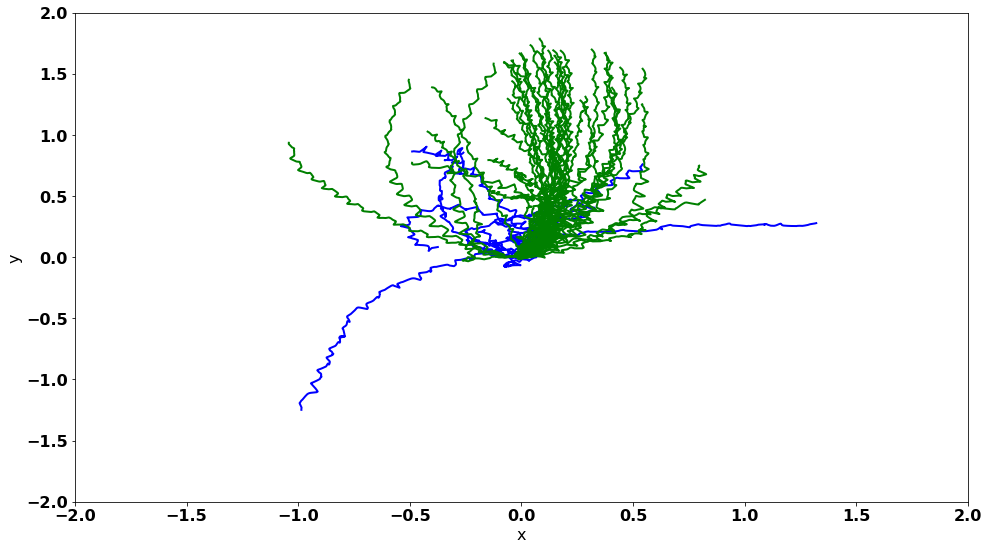

In [171]:
plt.subplots(figsize=(16,9))
for i in range(len(obs)):
    plt.plot(obs[i,:,0], obs[i,:,1], lw=2, color='b' if i<10 else 'g')
plt.xlabel('x')
plt.ylabel('y')
plt.ylim((-2,2))
plt.xlim((-2,2));

('best', 47)

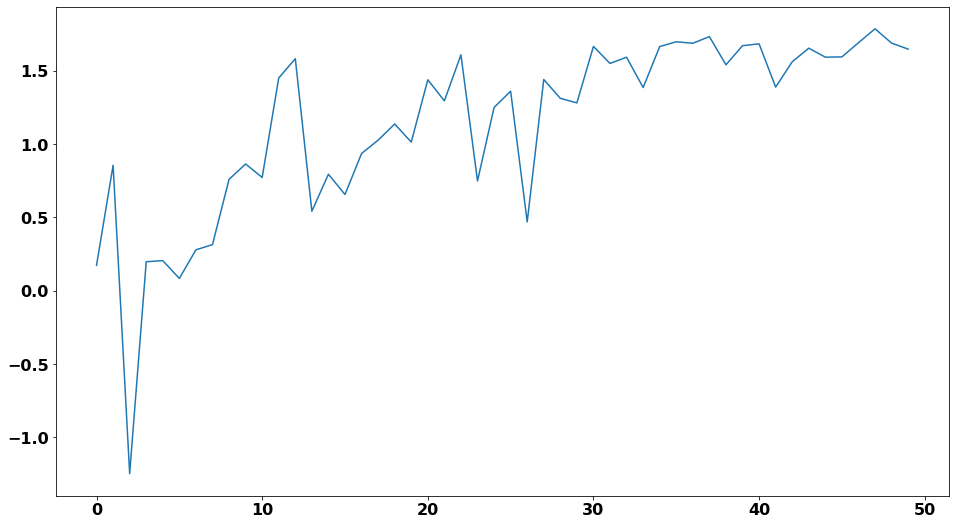

In [172]:
plt.subplots(figsize=(16,9))
plt.plot(reward)
best =  np.argmax(reward)
'best', best

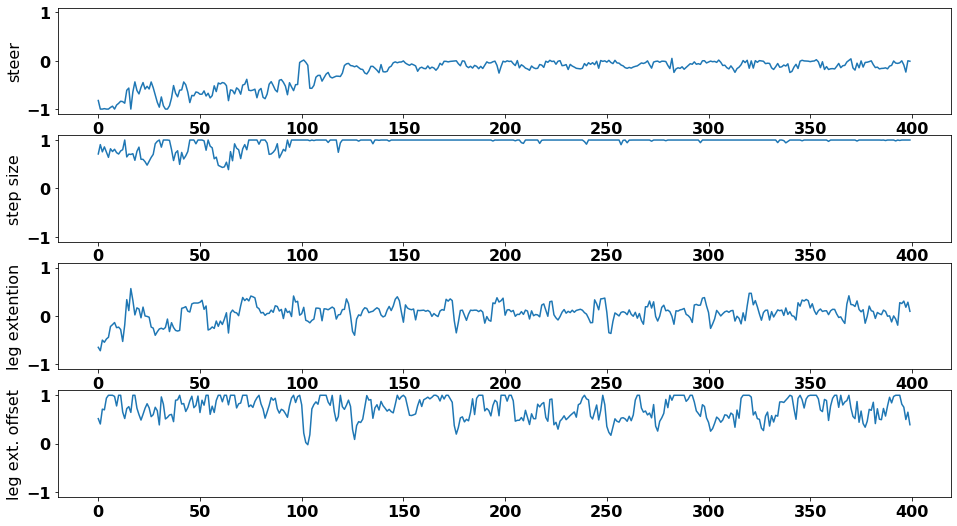

In [173]:
plot_controller(best+len(sol)-len(obs),sol)

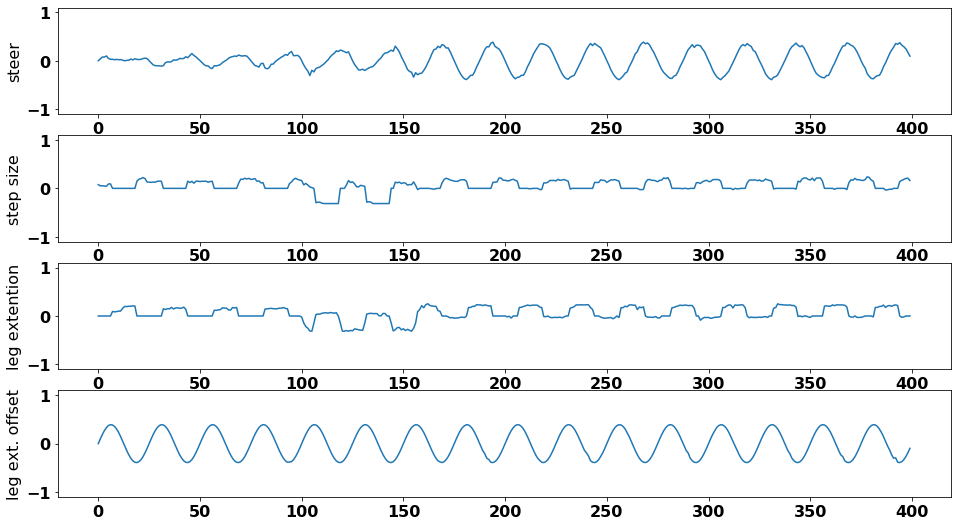

In [174]:
plot_controller(best+len(sol)-len(obs),acs)

In [157]:
with open("exp/data/pexod.pk", 'rb') as f:
    [S, R, C] =  pickle.load(f)
S = np.array(S)
R = np.array(R)

In [168]:
float('0')

0.0

SyntaxError: invalid syntax (<ipython-input-15-045f268cb4f1>, line 1)